In [ ]:
!pip install tensorflow==1.15

###  Importaciones

In [3]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
# from scipy.misc import imread, imresize, imsave, fromimage, toimage
from scipy.optimize import fmin_l_bfgs_b
import os
import numpy as np
from google.colab import files
import time
import argparse
import warnings
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.utils.layer_utils import convert_all_kernels_in_model

TH_19_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_th_dim_ordering_th_kernels_notop.h5'
TF_19_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'


## Funciones utiles (resize,imread,from_image,im_save,to_image 

In [4]:
import numpy as np
import imageio
from PIL import Image
from skimage import color


def imread(path, mode="RGB"):
    # Loads data in HxW format, then transposes to correct format
    img = np.array(imageio.imread(path, pilmode=mode))
    return img
    

def imresize(img, size, interp='bilinear'):
    """
    Resizes an image
    :param img:
    :param size: (Must be H, W format !)
    :param interp:
    :return:
    """
    if interp == 'bilinear':
        interpolation = Image.BILINEAR
    elif interp == 'bicubic':
        interpolation = Image.BICUBIC
    else:
        interpolation = Image.NEAREST

    # Requires size to be HxW
    size = (size[1], size[0])

    if type(img) != Image:
        img = Image.fromarray(img, mode='RGB')

    img = np.array(img.resize(size, interpolation))
    return img
    
    
def imsave(path, img):
    imageio.imwrite(path, img)
    return
    

def fromimage(img, mode='RGB'):
    if mode == 'RGB':
        img = color.lab2rgb(img)
    else:
        img = color.rgb2lab(img)
    return img


def toimage(arr, mode='RGB'):
    return Image.fromarray(arr, mode)

# Imagen de contenido


Saving 3.jpg to 3.jpg
Content image filename : 3.jpg


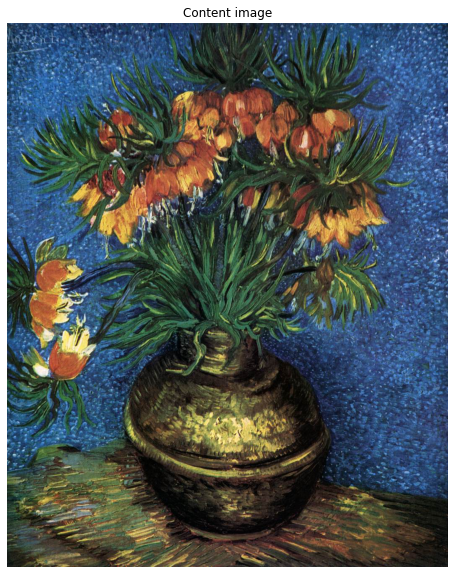

In [5]:
from google.colab import files
content_img = files.upload()


CONTENT_IMAGE_FN = list(content_img)[0]
CONTENT_IMAGE_FN_temp = CONTENT_IMAGE_FN.strip().replace(" ", "_")

if CONTENT_IMAGE_FN != CONTENT_IMAGE_FN_temp:
  os.rename(CONTENT_IMAGE_FN, CONTENT_IMAGE_FN_temp)
  CONTENT_IMAGE_FN = CONTENT_IMAGE_FN_temp
  
print("Content image filename :", CONTENT_IMAGE_FN)
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
img = plt.imread(CONTENT_IMAGE_FN)
plt.axis('off')
plt.title('Content image')
plt.imshow(img)

# Imagen de estilo

Saving 41994.jpg to 41994.jpg
Style image filename : 41994.jpg


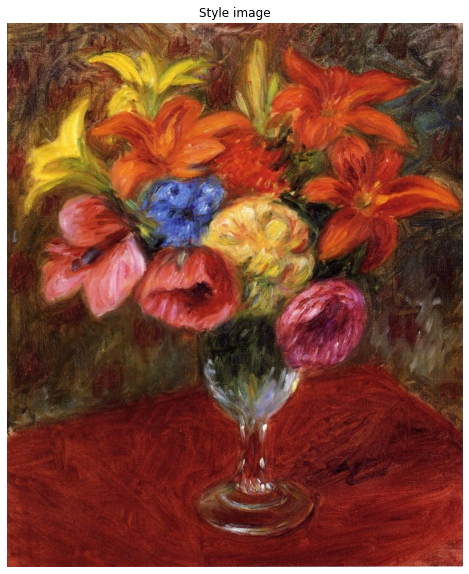

In [6]:
style_img = files.upload()
STYLE_IMAGE_FN = list(style_img)[0]
STYLE_IMAGE_FN_temp = STYLE_IMAGE_FN.strip().replace(" ", "_")

if STYLE_IMAGE_FN != STYLE_IMAGE_FN_temp:
  os.rename(STYLE_IMAGE_FN, STYLE_IMAGE_FN_temp)
  STYLE_IMAGE_FN = STYLE_IMAGE_FN_temp

print("Style image filename :", STYLE_IMAGE_FN)
fig = plt.figure(figsize=(10, 10))
img = plt.imread(STYLE_IMAGE_FN)
plt.axis('off')
plt.title('Style image')
plt.imshow(img)

# Parametros


In [7]:
def str_to_bool(v):
    return v.lower() in ("true", "yes", "t", "1")

# Image size
img_size= 500
# Loss Weights
content_weight = 0.025
style_weight = 1.0
style_scale = 1.0
tv_weight = 8.5e-5
content_loss_type = 0
color_mask = None
content_mask = None
style_masks = None
# Training arguments
num_iter = 10
use_model= 'vgg19'
rescale_image = 'false'
color = 'false'
maintain_aspect_ratio = 'false'
rescale_method = 'bilinear'
# Transfer Arguments
content_layer = 'conv' + '5_2'  # only change the number 5_2 to something in a similar format
init_image = 'content'
# Extra arguments
min_improvement = 0.0

RESULT_DIR = "Resultados/"
result_prefix = RESULT_DIR + "resultado"
FINAL_IMAGE_PATH = result_prefix + "_en_iteracion_%d.png" % (num_iter)
if not os.path.exists(RESULT_DIR):
  os.makedirs(RESULT_DIR)

base_image_path = CONTENT_IMAGE_FN
style_image_paths = [STYLE_IMAGE_FN]
style_masks_present = style_masks is not None
mask_paths = []
if style_masks_present:
    for mask_path in style_masks:
        mask_paths.append(mask_path)
content_mask_present = content_mask is not None
content_mask_path = content_mask
color_mask_present = color_mask is not None
rescale_image = str_to_bool(rescale_image)
maintain_aspect_ratio = str_to_bool(maintain_aspect_ratio)
preserve_color = str_to_bool(color)
style_weights = [1]
pooltype = 0 # 0 si es MAX y 1 si es AVG
read_mode = "color"
img_width = img_height = 0
img_WIDTH = img_HEIGHT = 0
aspect_ratio = 0

# Transferencia de estilo


### Pre-procesamiento de la imagen y de-proceso de la imagen

In [8]:
def preprocess_image(image_path, load_dims=False, read_mode="color"):
    global img_width, img_height, img_WIDTH, img_HEIGHT, aspect_ratio

    mode = "RGB" if read_mode == "color" else "L"
    img = imread(image_path, mode=mode)  # Prevents crashes due to PNG images (ARGB)

    if mode == "L":
        # Expand the 1 channel grayscale to 3 channel grayscale image
        temp = np.zeros(img.shape + (3,), dtype=np.uint8)
        temp[:, :, 0] = img
        temp[:, :, 1] = img.copy()
        temp[:, :, 2] = img.copy()

        img = temp

    if load_dims:
        img_WIDTH = img.shape[0]
        img_HEIGHT = img.shape[1]
        aspect_ratio = float(img_HEIGHT) / img_WIDTH

        img_width = img_size
        if maintain_aspect_ratio:
            img_height = int(img_width * aspect_ratio)
        else:
            img_height = img_size

    img = imresize(img, (img_width, img_height)).astype('float32')

    # RGB -> BGR
    img = img[:, :, ::-1]

    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68

    if K.image_data_format() == "channels_first":
        img = img.transpose((2, 0, 1)).astype('float32')

    img = np.expand_dims(img, axis=0)
    return img


# util function to convert a tensor into a valid image
def deprocess_image(x):
    if K.image_data_format() == "channels_first":
        x = x.reshape((3, img_width, img_height))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_width, img_height, 3))

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # BGR -> RGB
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Funciones de perdida de contenido y estilo 

In [9]:
# Gram matrix para una imagen
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == "channels_first":
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


##Pérdida de estilo
def style_loss(style, combination, mask_path=None, nb_channels=None):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_width * img_height
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))



#Loss de contenido
def content_loss(base, combination):
    channel_dim = 0 if K.image_data_format() == "channels_first" else -1

    try:
        channels = K.int_shape(base)[channel_dim]
    except TypeError:
        channels = K.shape(base)[channel_dim]
    size = img_width * img_height

    if content_loss_type == 1:
        multiplier = 1. / (2. * (channels ** 0.5) * (size ** 0.5))
    elif content_loss_type == 2:
        multiplier = 1. / (channels * size)
    else:
        multiplier = 1.

    return multiplier * K.sum(K.square(combination - base))

### Tensor representacion de la imagen base (contenido), de estilo y combinada

In [10]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path, True, read_mode=read_mode))
style_reference_images = []
for style_path in style_image_paths:
    style_reference_images.append(K.variable(preprocess_image(style_path)))
# this will contain our generated image
if K.image_data_format() == "channels_first":
    combination_image = K.placeholder((1, 3, img_width, img_height))
else:
    combination_image = K.placeholder((1, img_width, img_height, 3))

image_tensors = [base_image]
for style_image_tensor in style_reference_images:
    image_tensors.append(style_image_tensor)
image_tensors.append(combination_image)

nb_tensors = len(image_tensors)
nb_style_images = nb_tensors - 2 # Content and Output image not considered

# combine the various images into a single Keras tensor
input_tensor = K.concatenate(image_tensors, axis=0)

if K.image_data_format() == "channels_first":
    shape = (nb_tensors, 3, img_width, img_height)
else:
    shape = (nb_tensors, img_width, img_height, 3)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Import del modelo VGG19 con los pesos pre-entrenados

In [11]:
def pooling_func(x):
    if pooltype == 1:
        return AveragePooling2D((2, 2), strides=(2, 2))(x)
    else:
        return MaxPooling2D((2, 2), strides=(2, 2))(x)

input_model = Input(tensor=input_tensor, batch_shape=shape)

# build the VGG16 network with our 3 images as input
x = Convolution2D(64, (3, 3), activation='relu', name='conv1_1', padding='same')(input_model)
x = Convolution2D(64, (3, 3), activation='relu', name='conv1_2', padding='same')(x)
x = pooling_func(x)

x = Convolution2D(128, (3, 3), activation='relu', name='conv2_1', padding='same')(x)
x = Convolution2D(128, (3, 3), activation='relu', name='conv2_2', padding='same')(x)
x = pooling_func(x)

x = Convolution2D(256, (3, 3), activation='relu', name='conv3_1', padding='same')(x)
x = Convolution2D(256, (3, 3), activation='relu', name='conv3_2', padding='same')(x)
x = Convolution2D(256, (3, 3), activation='relu', name='conv3_3', padding='same')(x)
if use_model == "vgg19":
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_4', padding='same')(x)
x = pooling_func(x)

x = Convolution2D(512, (3, 3), activation='relu', name='conv4_1', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv4_2', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv4_3', padding='same')(x)
if use_model == "vgg19":
    x = Convolution2D(512, (3, 3), activation='relu', name='conv4_4', padding='same')(x)
x = pooling_func(x)

x = Convolution2D(512, (3, 3), activation='relu', name='conv5_1', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv5_2', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv5_3', padding='same')(x)
if use_model == "vgg19":
    x = Convolution2D(512, (3, 3), activation='relu', name='conv5_4', padding='same')(x)
x = pooling_func(x)

model = Model(input_model, x)

if K.image_data_format() == "channels_first":
  if use_model == "vgg19":
    weights = get_file('vgg19_weights_th_dim_ordering_th_kernels_notop.h5', TH_19_WEIGHTS_PATH_NO_TOP, cache_subdir='models')
else:
  if use_model == "vgg19":
    weights = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', TF_19_WEIGHTS_PATH_NO_TOP, cache_subdir='models')

model.load_weights(weights)

if K.backend() == 'tensorflow' and K.image_data_format() == "channels_first":
    warnings.warn('You are using the TensorFlow backend, yet you '
                  'are using the Theano '
                  'image dimension ordering convention '
                  '(`image_dim_ordering="th"`). '
                  'For best performance, set '
                  '`image_dim_ordering="tf"` in '
                  'your Keras config '
                  'at ~/.keras/keras.json.')
    convert_all_kernels_in_model(model)
print('Model loaded.')

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
shape_dict = dict([(layer.name, layer.output_shape) for layer in model.layers])


80142336/80134624 [==============================] - 8s 0us/step
Model loaded.


### Seteo de la función de loss combinada (loss + style) al tensor, junto a la evalución de la loss y gradiente

In [12]:
# Se combinan ambas loss
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]  # 'conv5_2' or 'conv4_2'
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[nb_tensors - 1, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                      combination_features)
style_masks = []
if style_masks_present:
    style_masks = mask_paths # If mask present, pass dictionary of masks to style loss
else:
    style_masks = [None for _ in range(nb_style_images)] # If masks not present, pass None to the style loss

channel_index = 1 if K.image_data_format() == "channels_first" else -1

feature_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    shape = shape_dict[layer_name]
    combination_features = layer_features[nb_tensors - 1, :, :, :]

    style_reference_features = layer_features[1:nb_tensors - 1, :, :, :]
    sl = []
    for j in range(nb_style_images):
        sl.append(style_loss(style_reference_features[j], combination_features, style_masks[j], shape))

    for j in range(nb_style_images):
        loss = loss + (style_weights[j] / len(feature_layers)) * sl[j]

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

In [13]:
def eval_loss_and_grads(x):
    if K.image_data_format() == "channels_first":
        x = x.reshape((1, 3, img_width, img_height))
    else:
        x = x.reshape((1, img_width, img_height, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


In [14]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
evaluator = Evaluator()


### Función main: Se preprocesa la imagen de entrada (se ocupa la misma de contenido). 

Se itera 10 veces utilizando la función de optmiización f_min_l_bfgs_b, guardando los resultados en la carpeta Resultados

In [15]:
if "content" in init_image or "gray" in init_image:
    x = preprocess_image(base_image_path, True, read_mode=read_mode)
elif "noise" in init_image:
    x = np.random.uniform(0, 255, (1, img_width, img_height, 3)) - 128.
    if K.image_data_format() == "channels_first":
        x = x.transpose((0, 3, 1, 2))
else:
    x = preprocess_image(init_image, read_mode=read_mode)

num_iter = num_iter
prev_min_val = -1

improvement_threshold = float(min_improvement)
for i in range(num_iter):
    print("Iteración %d of %d" % ((i + 1), num_iter))
    start_time = time.time()

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print(min_val)
    if prev_min_val == -1:
        prev_min_val = min_val

    improvement = (prev_min_val - min_val) / prev_min_val * 100

    print('Loss value:', min_val, " Improvement : %0.3f" % improvement, "%")
    prev_min_val = min_val
    # save current generated image
    img = deprocess_image(x.copy())

    if not rescale_image:
        img_ht = int(img_width * aspect_ratio)
        img = imresize(img, (img_width, img_ht), interp=rescale_method)

    if rescale_image:
        img = imresize(img, (img_WIDTH, img_HEIGHT), interp=rescale_method)

    fname = result_prefix + '_en_iteracion_%d.png' % (i + 1)
    imsave(fname, img)
    end_time = time.time()
    print('Imagen guardada en', fname)
    print('Iteración %d completada in %ds' % (i + 1, end_time - start_time))

Iteración 1 of 10
742496100.0
Loss value: 742496100.0  Improvement : 0.000 %
Imagen guardada en Resultados/resultado_en_iteracion_1.png
Iteración 1 completada in 18s
Iteración 2 of 10
377256900.0
Loss value: 377256900.0  Improvement : 49.191 %
Imagen guardada en Resultados/resultado_en_iteracion_2.png
Iteración 2 completada in 8s
Iteración 3 of 10
270365660.0
Loss value: 270365660.0  Improvement : 28.334 %
Imagen guardada en Resultados/resultado_en_iteracion_3.png
Iteración 3 completada in 8s
Iteración 4 of 10
214391920.0
Loss value: 214391920.0  Improvement : 20.703 %
Imagen guardada en Resultados/resultado_en_iteracion_4.png
Iteración 4 completada in 8s
Iteración 5 of 10
181526380.0
Loss value: 181526380.0  Improvement : 15.330 %
Imagen guardada en Resultados/resultado_en_iteracion_5.png
Iteración 5 completada in 9s
Iteración 6 of 10
159124740.0
Loss value: 159124740.0  Improvement : 12.341 %
Imagen guardada en Resultados/resultado_en_iteracion_6.png
Iteración 6 completada in 8s
Iter

### Resultados

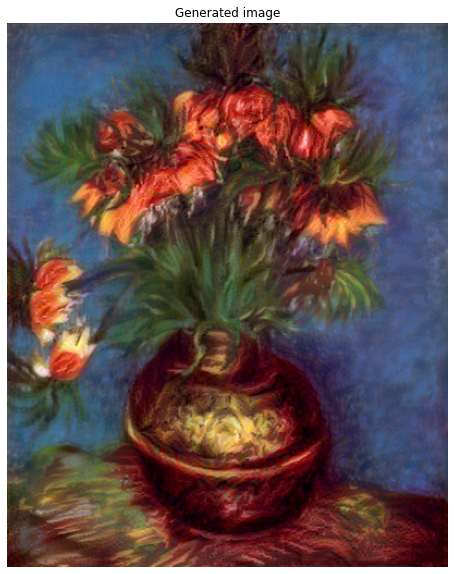

In [19]:
fig = plt.figure(figsize=(10, 10))
img = plt.imread(FINAL_IMAGE_PATH)
plt.axis('off')
plt.title('Generated image')
plt.imshow(img)

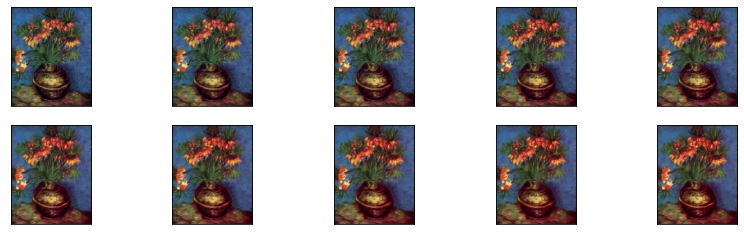

In [20]:
plt.figure(figsize=(14,4))
imgs = []
for j in range(10):
  cont=j+1
  imagen = plt.imread('Resultados/resultado_en_iteracion_'+str(cont)+'.png')
  imgs.append(imagen)
for i,img in enumerate(imgs):
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])